# Data Wrangling with Spark

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.types import StructType, StructField, IntegerType

from pyspark.sql import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Data Exploration 

The next cells explore the data set.

In [0]:
path = "/FileStore/tables/riders.csv"
df_riders = spark.read \
    .option("inferSchema", "true") \
    .option("header", "false") \
    .option("sep", ",") \
    .format("csv") \
    .load(path) \
    .withColumnRenamed("_c0","rider_id") \
    .withColumnRenamed("_c1","firstName")\
    .withColumnRenamed("_c2","lastName")\
    .withColumnRenamed("_c3","address")\
    .withColumnRenamed("_c4","birthday")\
    .withColumnRenamed("_c5","startDate")\
    .withColumnRenamed("_c6","endDate")\
    .withColumnRenamed("_c7","isMember")


In [0]:
df_riders.take(2)

Out[30]: [Row(rider_id=1000, firstName='Diana', lastName='Clark', address='1200 Alyssa Squares', birthday=datetime.datetime(1989, 2, 13, 0, 0), startDate=datetime.datetime(2019, 4, 23, 0, 0), endDate=None, isMember=True),
 Row(rider_id=1001, firstName='Jennifer', lastName='Smith', address='397 Diana Ferry', birthday=datetime.datetime(1976, 8, 10, 0, 0), startDate=datetime.datetime(2019, 11, 1, 0, 0), endDate=datetime.datetime(2020, 9, 1, 0, 0), isMember=True)]

In [0]:
df_riders.printSchema()

root
-- rider_id: integer (nullable = true)
-- firstName: string (nullable = true)
-- lastName: string (nullable = true)
-- address: string (nullable = true)
-- birthday: timestamp (nullable = true)
-- startDate: timestamp (nullable = true)
-- endDate: timestamp (nullable = true)
-- isMember: boolean (nullable = true)

In [0]:
display(df_riders.describe())

summary,rider_id,firstName,lastName,address,birthday,startDate,endDate,isMember
count,75000,75000,75000,75000,75000,75000,14954,75000
mean,38499.5,null,null,null,null,null,null,null
stddev,21650.77943169714,null,null,null,null,null,null,null
min,1000,Aaron,Abbott,000 Alicia Route,1946-03-24,2013-01-31,2013-03-01,False
max,9999,Zoe,Zuniga,99999 Johnson Crescent,2006-02-17,2022-02-12,2022-02-01,True


In [0]:
display(df_riders.describe("firstName"))

summary,firstName
count,75000
mean,null
stddev,null
min,Aaron
max,Zoe


In [0]:
df_riders.describe("firstName").show()

+-------+---------+
summary|firstName|
+-------+---------+
 count| 75000|
 mean| null|
 stddev| null|
 min| Aaron|
 max| Zoe|
+-------+---------+

In [0]:
df_riders.count()

Out[12]: 75000

In [0]:
df_riders.select("firstName").dropDuplicates().sort("firstName").show()

+----------+
 firstName|
+----------+
 Aaron|
 Abigail|
 Adam|
 Adrian|
 Adriana|
 Adrienne|
 Aimee|
 Alan|
 Albert|
 Alec|
 Alejandra|
 Alejandro|
 Alex|
 Alexa|
 Alexander|
 Alexandra|
Alexandria|
 Alexis|
 Alfred|
 Alice|
+----------+
only showing top 20 rows

In [0]:
df_riders \
    .select(["rider_id", "firstName", "lastName", "isMember"]) \
    .where(df_riders.rider_id == "1000") \
    .collect() 

Out[25]: [Row(rider_id='1000', firstName='Diana', lastName='Clark', isMember='True')]

# Calculating Statistics by Hour

In [0]:
get_hour = udf(lambda x: x.day if not x is None else -1, IntegerType())

In [0]:
df_riders = df_riders.withColumn("day", get_hour(df_riders.startDate))
df_riders.select("day").show()

+---+
day|
+---+
 23|
 1|
 4|
 26|
 14|
 24|
 27|
 11|
 28|
 12|
 27|
 20|
 16|
 28|
 24|
 10|
 2|
 11|
 25|
 10|
+---+
only showing top 20 rows

In [0]:
count_members_per_day = df_riders \
    .filter(df_riders.isMember == True) \
    .groupby(df_riders.day) \
    .count() \
    .orderBy(df_riders.day)

count_members_per_day_pd = count_members_per_day.toPandas()

In [0]:
count_members_per_day.show()

+---+-----+
day|count|
+---+-----+
 1| 1972|
 2| 1987|
 3| 1957|
 4| 2037|
 5| 2011|
 6| 2055|
 7| 1929|
 8| 1950|
 9| 1972|
 10| 2016|
 11| 2043|
 12| 2024|
 13| 1939|
 14| 1978|
 15| 1958|
 16| 1924|
 17| 1976|
 18| 1917|
 19| 1969|
 20| 1899|
+---+-----+
only showing top 20 rows

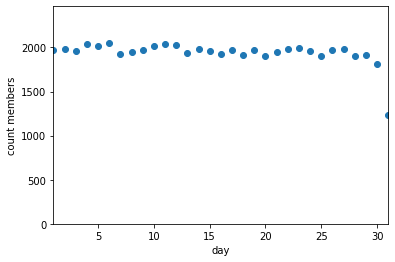

In [0]:
plt.scatter(count_members_per_day_pd["day"], count_members_per_day_pd["count"])
plt.xlim(1, 31);
plt.ylim(0, 1.2 * max(count_members_per_day_pd["count"]))
plt.xlabel("Day")
plt.ylabel("Count members");

# Drop Rows with Missing Values

In [0]:
df_riders_valid = df_riders.dropna(how = "any", subset = ["rider_id", "firstName"])

In [0]:
df_riders_valid.count()

Out[78]: 75000

In [0]:
df_riders.select("rider_id").dropDuplicates().sort("rider_id").show()

+--------+
rider_id|
+--------+
 1000|
 1001|
 1002|
 1003|
 1004|
 1005|
 1006|
 1007|
 1008|
 1009|
 1010|
 1011|
 1012|
 1013|
 1014|
 1015|
 1016|
 1017|
 1018|
 1019|
+--------+
only showing top 20 rows

In [0]:
df_riders_valid = df_riders_valid.filter(df_riders_valid["rider_id"] != "")

In [0]:
df_riders_valid.count()

Out[82]: 0

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [0]:
flag_is_member = udf(lambda x: 1 if x == True else 0, IntegerType())

In [0]:
df_riders = df_riders.withColumn("isMemberFlag", flag_is_member("isMember"))

In [0]:
windowval = Window.partitionBy("rider_id").orderBy(desc("startDate")).rangeBetween(Window.unboundedPreceding, 0)

In [0]:
df_riders = df_riders.withColumn("phase", Fsum("isMemberFlag").over(windowval))

In [0]:
df_riders \
    .select(["rider_id", "firstName", "lastName", "startDate", "endDate", "isMember", "phase"]) \
    .where(df_riders.rider_id == "1200") \
    .sort("startDate") \
    .collect()

Out[95]: [Row(rider_id=1200, firstName='Scott', lastName='Morris', startDate=datetime.datetime(2021, 12, 17, 0, 0), endDate=datetime.datetime(2022, 1, 1, 0, 0), isMember=True, phase=1)]